======================== Import Packages ==========================

In [1]:
import sys, os, pdb, glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.patches import Ellipse
from astropy.io import fits
from astropy.table import Table, join
from astropy.coordinates import SkyCoord
from astropy import units as u
plt.rcParams.update({'figure.max_open_warning': 0})
from astroquery.vizier import Vizier
import warnings
from astropy.logger import AstropyWarning
warnings.filterwarnings('ignore', category=AstropyWarning)

===================== Define Functions ===================

In [2]:
def get_data(catalog, join_key='Name', join_type='inner'):

    """
    PURPOSE:    Get data from literature with Vizier

    INPUT:      catalog = ctalog name on Vizier (str)
                join_key = column header to join tables, if multiple (str; optional)
                join_type = way to join tables, if multiple (str; optional)

    OUTPUT:     t = data table (AstroPy Table)

    """

    ### GET FULL CATALOG (ALL COLUMNS, ALL ROWS)
    viz = Vizier(catalog=catalog, columns=['**'])
    viz.ROW_LIMIT = -1
    tv = viz.get_catalogs(catalog)

    ### IF MULTIPLE TABLES, JOIN THEN
    for i, val in enumerate(tv.keys()):
        if i == 0:
            t = tv[val]
        else:
            tt = tv[val]
            if join_key in tt.columns:
                t = join(t, tt, join_type=join_type, keys=join_key)

    return t

In [3]:
def readfits(file):

    """
    PURPOSE:    Read in FITS file and header info

    INPUT:      file = path to FITS file (str)

    OUTPUT:     data = image data (2x2 float arr)
                xcen, ycen = image center coordinates in pixels (float)
                xpix, ypix = image pixel width in deg/pix units (float)
                xcen_ra, xcen_de = image center coordinates in deg units (float)
                bmaj, bmin = beam major & minor axis in arcsec (float)
                bpa = beam position angle in deg (float)

    """

    hdulist = fits.open(file)
    data = hdulist[0].data[0, 0, :, :]
    head = hdulist[0].header
    hdulist.close()

    xcen = head['CRPIX1']
    ycen = head['CRPIX2']
    xpix = head['CDELT1']
    ypix = head['CDELT2']
    xcen_ra = head['CRVAL1']
    xcen_de = head['CRVAL2']

    bmaj = head['BMAJ'] * 3600
    bmin = head['BMIN'] * 3600
    bpa = head['BPA']

    return(data, xcen, ycen, xpix, ypix, xcen_ra, xcen_de, bmaj, bmin, bpa)

In [4]:
def get_image(target, hw_as, suffix):

    """
    PURPOSE:    Read in FITS file and header info

    INPUT:      target = target name (str)
                hw_as = half-width of image size in arcsec (float)
                suffix = suffix of image name (str)

    OUTPUT:     img = cropped and centred image data (2x2 float arr)
                beam = beam major axis, minor axis, position angle (list of floats)

    """

    ### GET IMAGE FILE NAME
    file_img = '../data/FITS/' + target.replace(' ', '_') + suffix + '.fits'
    if os.path.isfile(file_img) is False:
        print('missing FITS file for ' + target)
        print(file_img)
        pdb.set_trace()

    ### LOAD IMAGE AND GET CENTER COORDINATES
    img, xcen_img, ycen_img, xpix_img, ypix_img, xcen_ra, ycen_de, bmaj, bmin, bpa = readfits(file_img)
    c_img = SkyCoord(xcen_ra, ycen_de, frame='icrs', unit='deg')
    beam = [bmaj, bmin, bpa]
        
    ### CENTER IMAGE ON OBJECT LOCATION 
    dra, ddec = c_img.spherical_offsets_to(c_obj)
    width_pix = int(round(hw_as / (ypix_img * 3600.0)))
    xctr = xcen_img + dra.value / xpix_img
    yctr = ycen_img + ddec.value / ypix_img

    ### CROP IMAGE AND PUT INTO mJy UNITS
    img = 1e3 * img[int(round(yctr - width_pix)):int(round(yctr + width_pix)),
                    int(round(xctr - width_pix)):int(round(xctr + width_pix))]

    return img, beam

In [5]:
def add_beam(bmj, bmn, bpa, sx, sy, bcol, ax):

    """
    PURPOSE:    Add beam to image

    INPUT:      bmj, bmn= beam major & minor axis in arcsec (float)
                bpa = beam position angle in degrees (float)
                sx, sy = location to plot beam (float)
                bcol = color of beam for plotting (str)
                ax = ax to plot beam (matplotlib ax)

    OUTPUT:     ax, but now with beam plotted (matplotlib ax) 

    """

    epa = 90. + bpa
    ell = Ellipse(xy=(sx, sy), width=bmj, height=bmn, angle=epa, edgecolor=bcol,
                  fc='None', linewidth=1.0, linestyle='solid')
    ax.add_patch(ell)

    return ax

In [6]:
def get_ccont(snr):

    """
    PURPOSE:    Get sigma contour levels for plotting
    INPUT:      snr = continuum signal-to-noise (float)
    OUTPUT:     ccont = sigma contour levels (list of floats)

    """

    if (snr >= 300.): ccont = np.array([3.,50.,170.]) 
    if (snr >= 150.) and (snr < 300.): ccont = np.array([3.,30.,60.]) 
    if (snr >= 80.) and (snr < 150.): ccont = np.array([3.,15.,40.]) 
    if (snr >= 20.) and (snr < 80.): ccont = np.array([3.,10.,25.]) 
    if (snr < 20.): ccont = np.array([3.,5.,10.])

    return ccont

========================== Code ==========================

In [7]:
## HALF WIDTH OF IMAGES FOR PLOTTING (ARCSEC)
hw_as = 1.5   

In [8]:
### IMAGE RMS FOR 13CO (NOT PROVIDED IN PAPER TABLES, NEEDED FOR PLOTTING IMAGES)
rms_13co = np.array([47, 73, 51, 30, 38, 73, 33, 68, 75, 33, 30, 52, 41, 64, 42, 45, 51,
                     29, 50, 30, 36, 59, 56, 27, 28, 51, 31, 36, 34, 27, 30, 49, 32, 31,
                     30, 30, 29, 32, 32, 32, 31, 26, 39, 30, 28, 35, 31, 59, 28, 31, 32,
                     30, 49, 32, 66, 32, 30, 32, 28, 24, 32, 47, 29, 42, 22, 45, 44, 45,
                     49, 30, 46, 44, 44, 48, 30, 48, 48, 30, 54, 31, 28, 48, 28, 24, 31,
                     28, 49, 49])

In [9]:
### IMAGE RMS FOR C18O (NOT PROVIDED IN PAPER TABLES, NEEDED FOR PLOTTING IMAGES)
rms_18co = np.array([56, 85, 61, 36, 46, 89, 37, 79, 76, 37, 34, 61, 48, 80, 48, 78, 62,
                     35, 60, 36, 40, 63, 69, 32, 35, 61, 37, 45, 39, 34, 35, 58, 37, 35,
                     34, 36, 35, 41, 34, 38, 35, 30, 39, 36, 34, 40, 34, 60, 34, 36, 38,
                     34, 58, 38, 80, 40, 35, 36, 33, 34, 37, 55, 34, 52, 33, 56, 56, 57,
                     57, 31, 57, 52, 52, 53, 32, 57, 55, 37, 64, 35, 32, 58, 34, 34, 36,
                     34, 58, 59])

In [10]:
#### LOAD IN LUPUS DATA
T = get_data("J/ApJ/828/46")

In [11]:
### REMOVE Sz 82 SINCE USED EXISTING OBS IN PAPER
### SORT BY DECREASING FLUX
T = T[np.where(T["Name"] != "Sz 82")]
T.sort('F890')
T.reverse()

In [12]:
### SETUP PLOT
mpl.rc('xtick.major',size=2,width=1)
mpl.rc('ytick.major',size=2,width=1)
mpl.rc('axes',linewidth=1,edgecolor='black')
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'

In [13]:
### SETUP PDF
pdf_pages = PdfPages('../output/figure_10.pdf')
nb_col, nb_row = 3, 4
nb_plots = nb_col * len(T)
nb_plots_per_page = nb_col * nb_row
nb_pages = int(np.ceil(nb_plots / float(nb_plots_per_page)))
grid_size = (nb_row,nb_col)
grid_pos = []
for j in range(nb_row):
    for i in range(nb_col):
      temp = [j,i]
      grid_pos.append(temp)

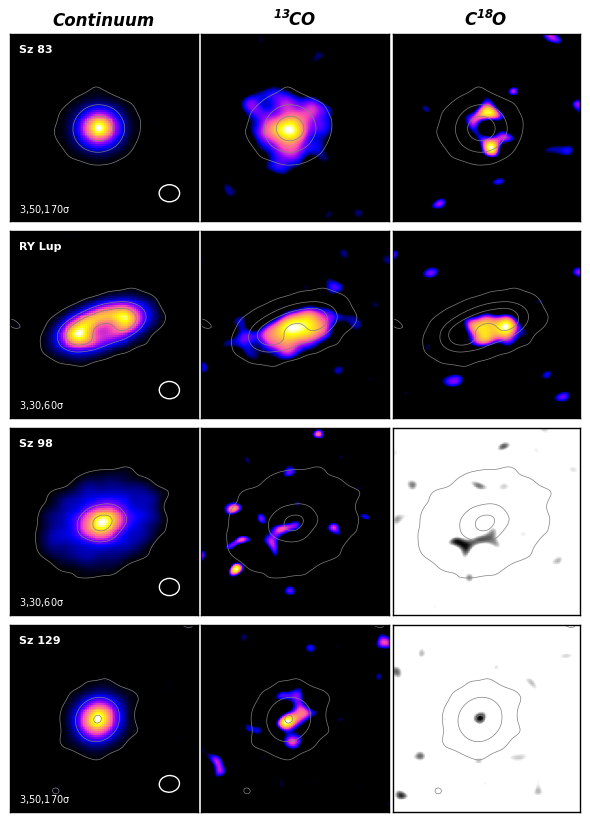

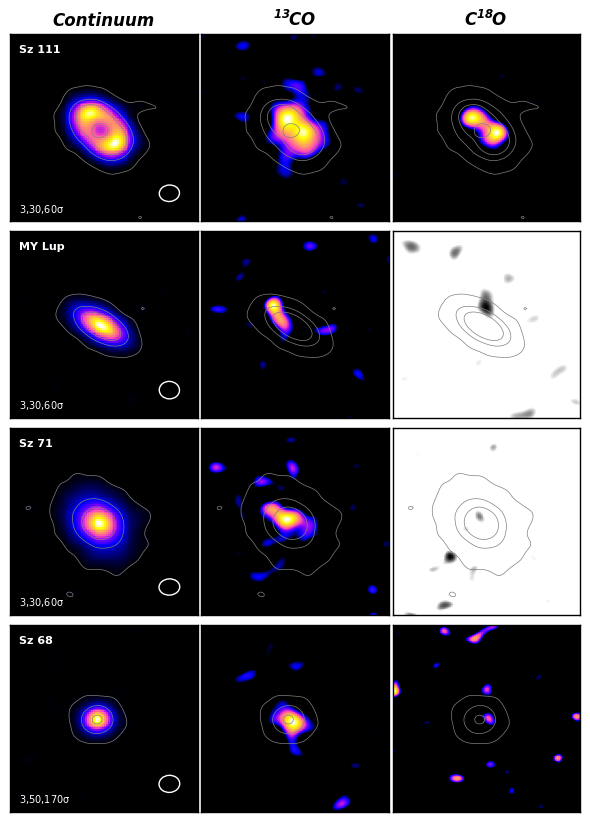

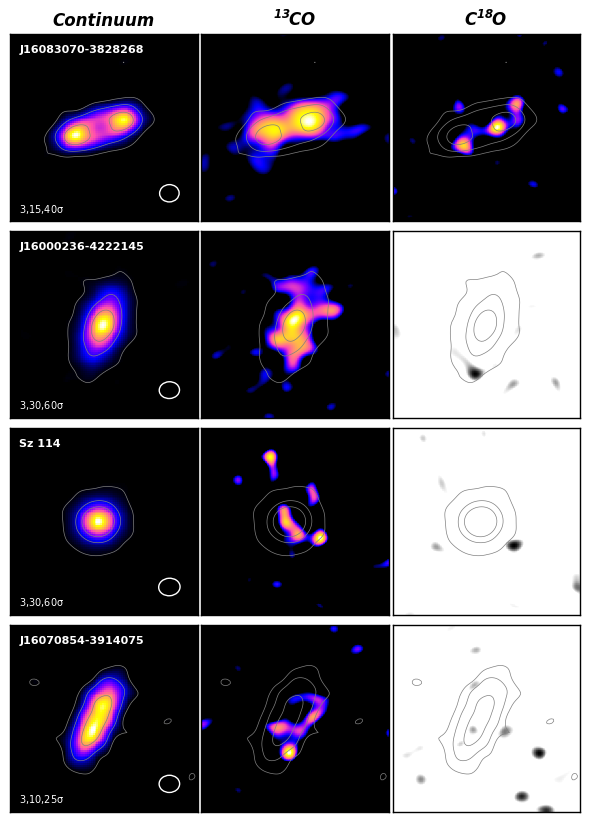

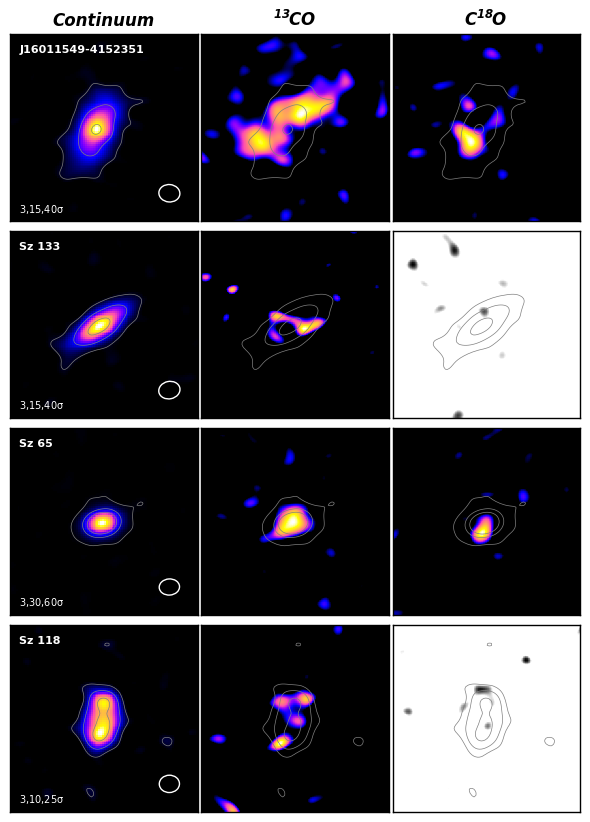

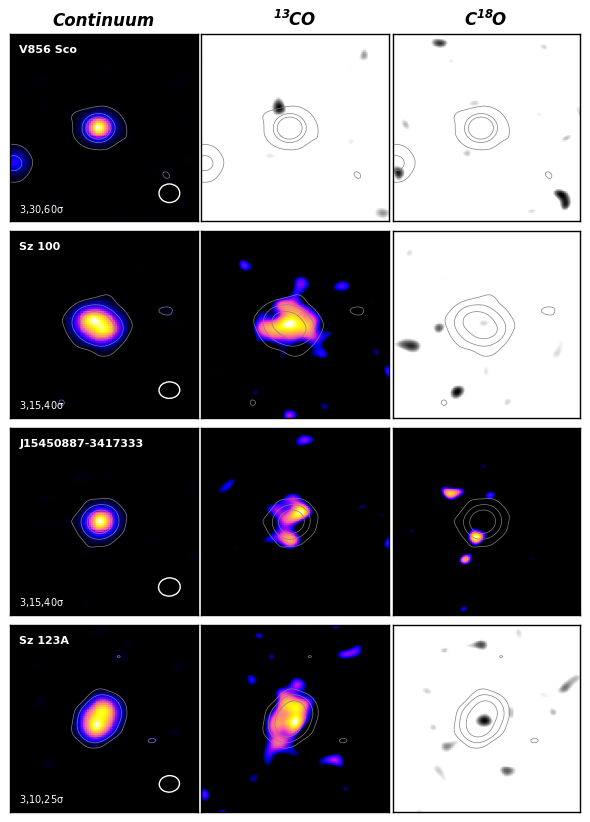

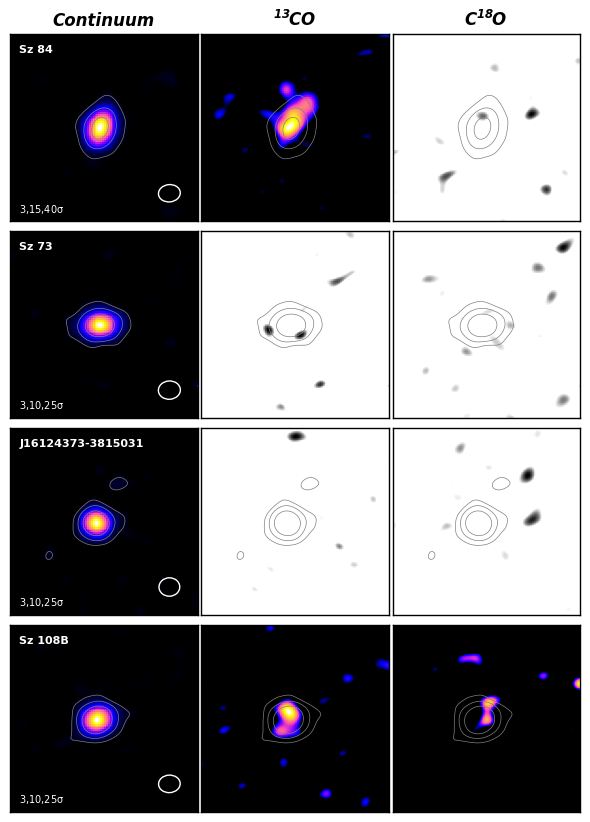

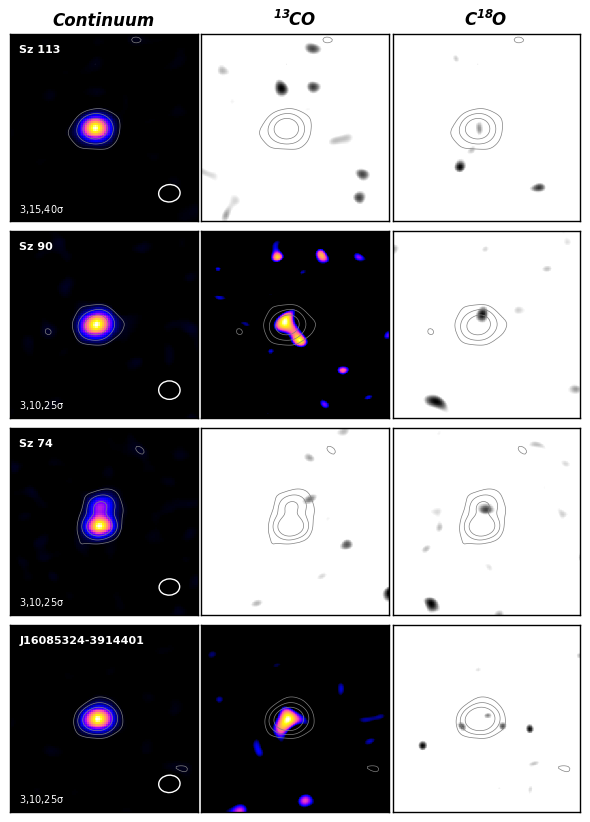

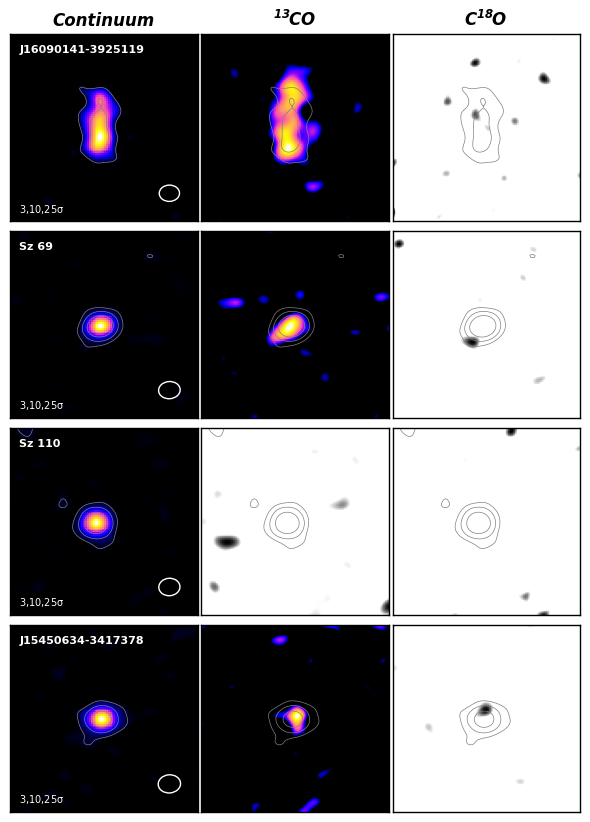

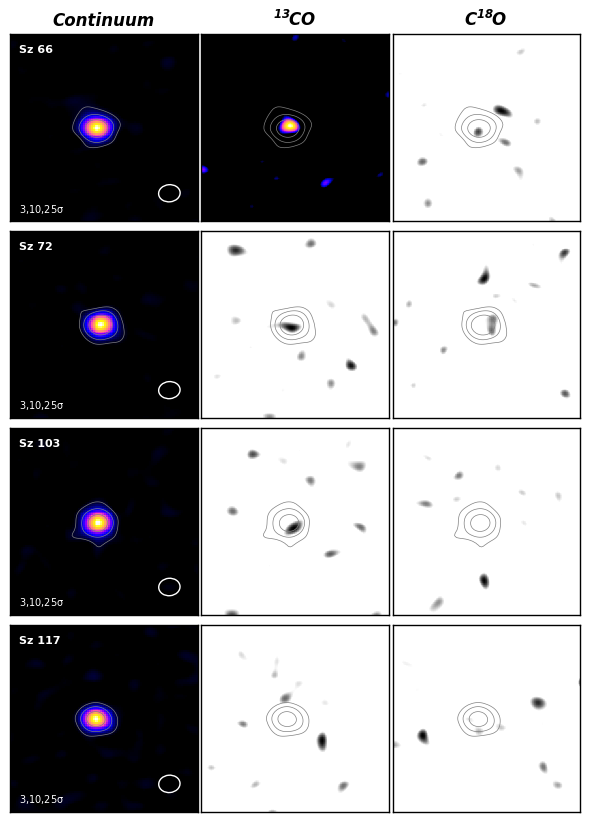

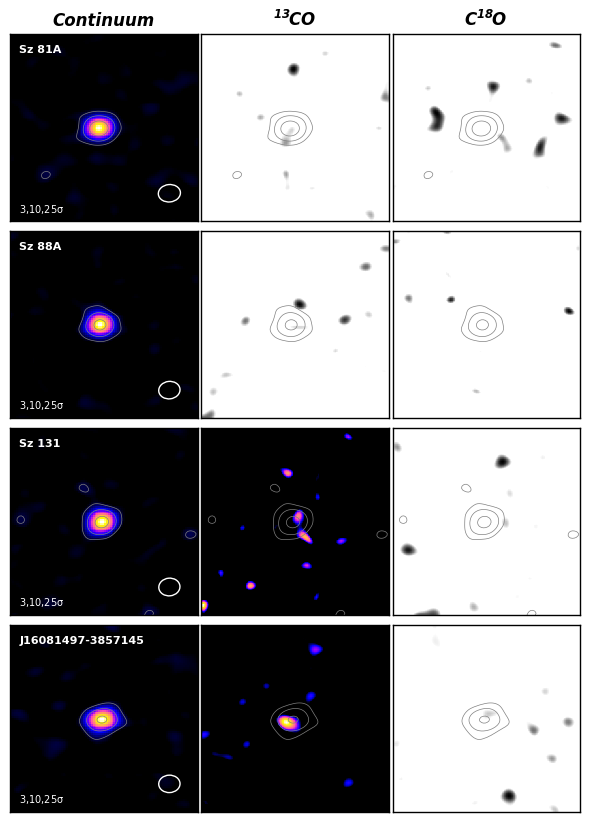

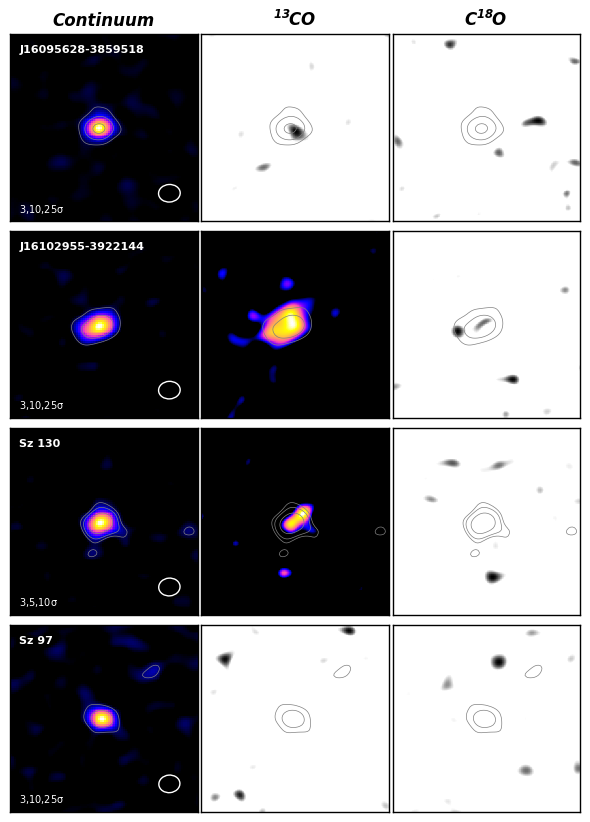

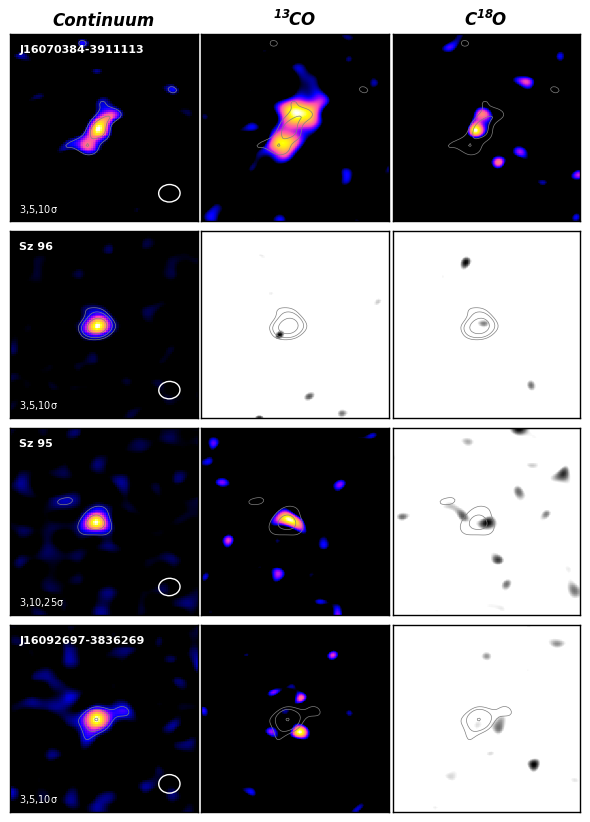

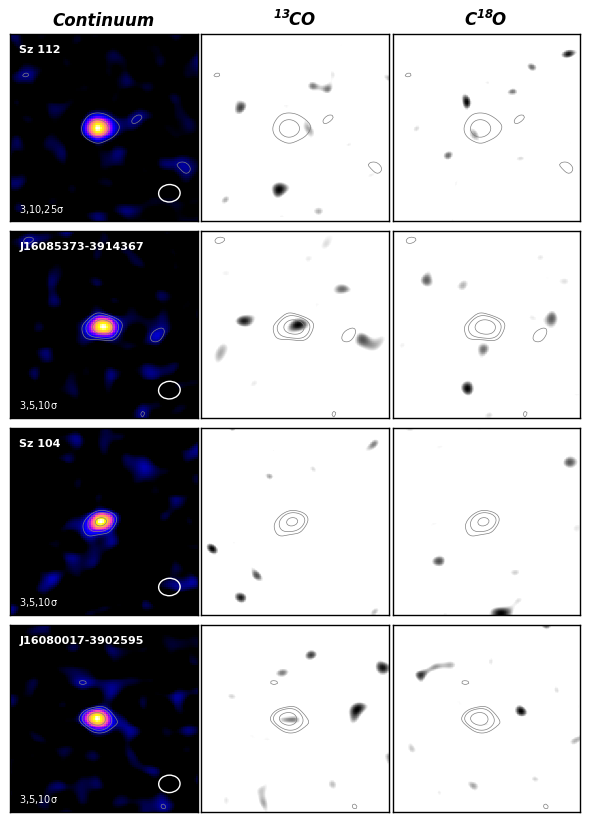

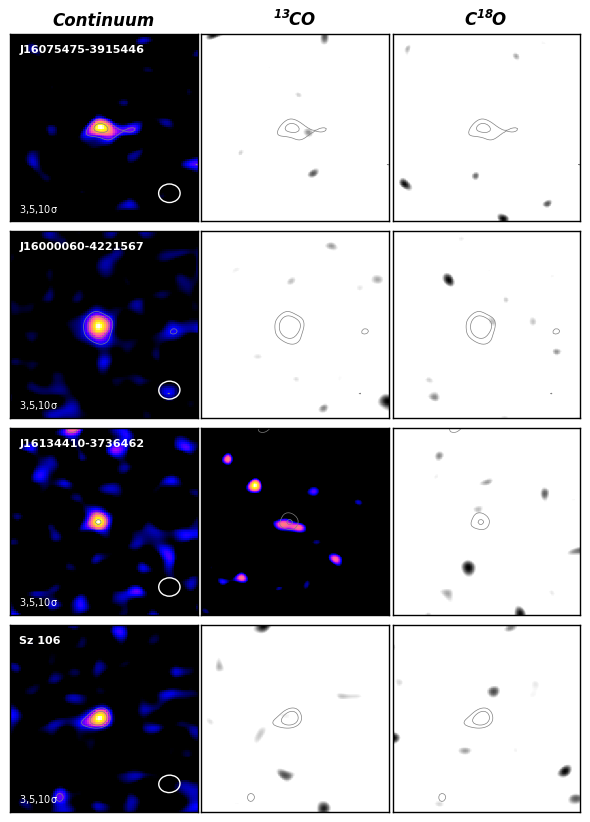

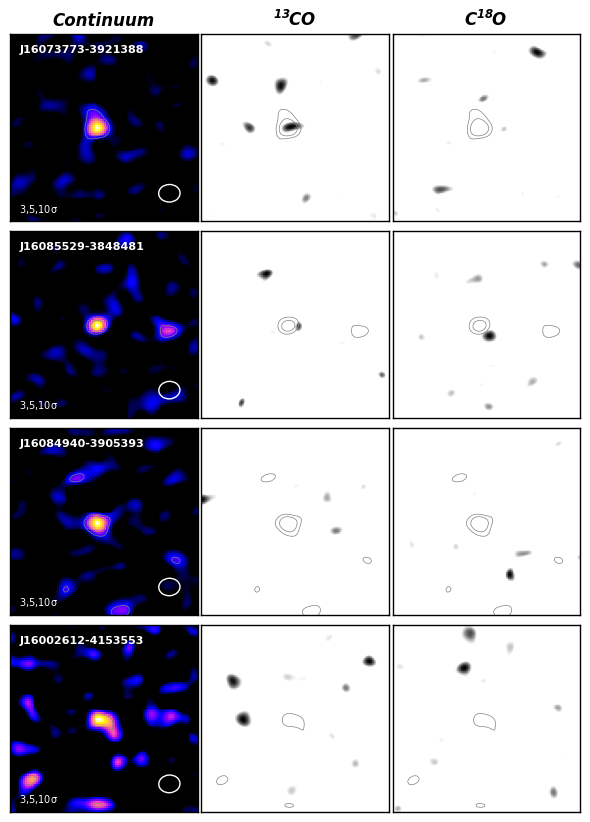

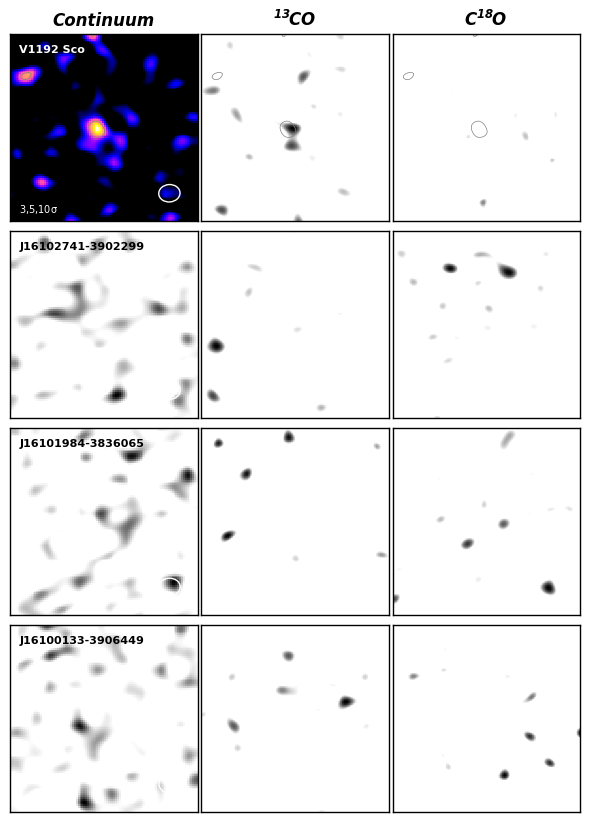

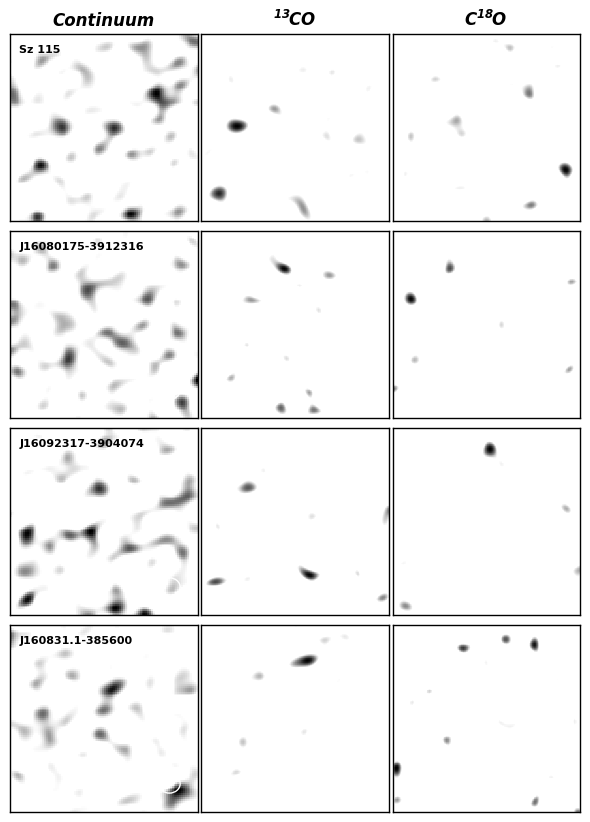

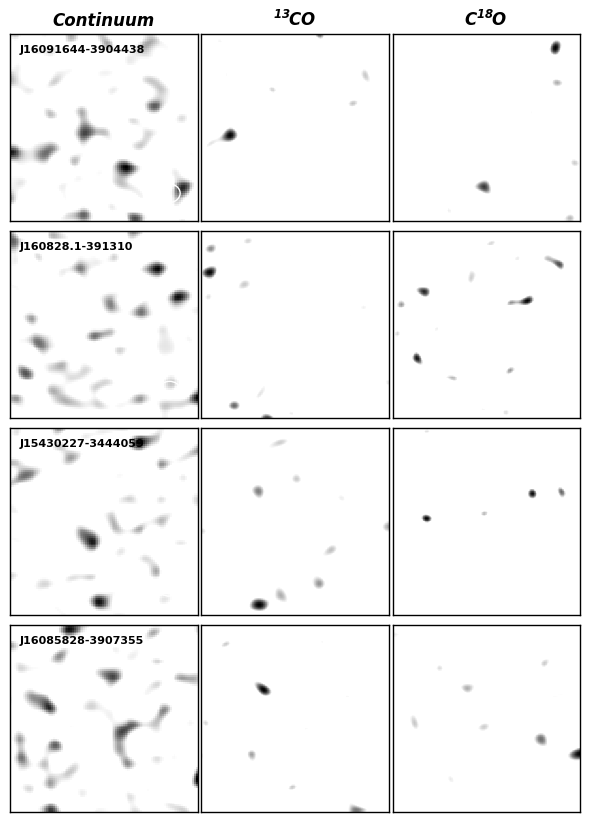

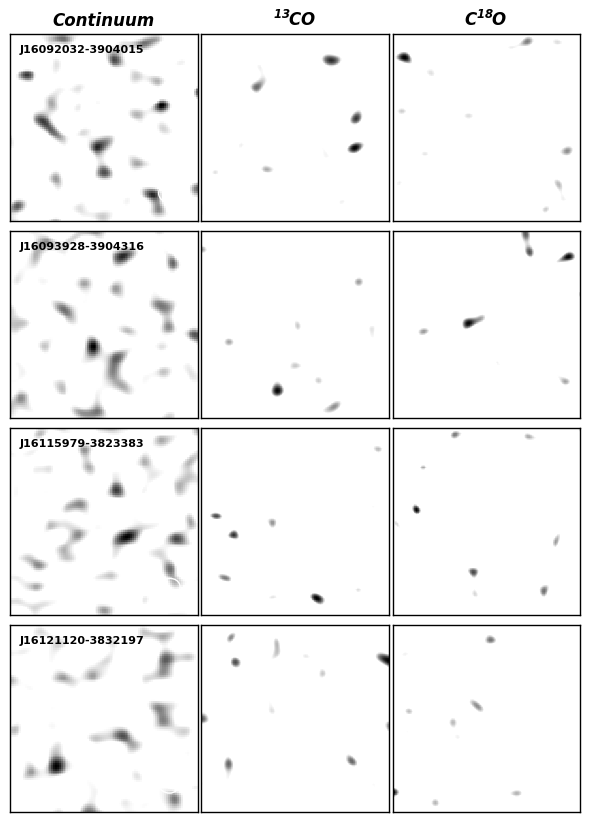

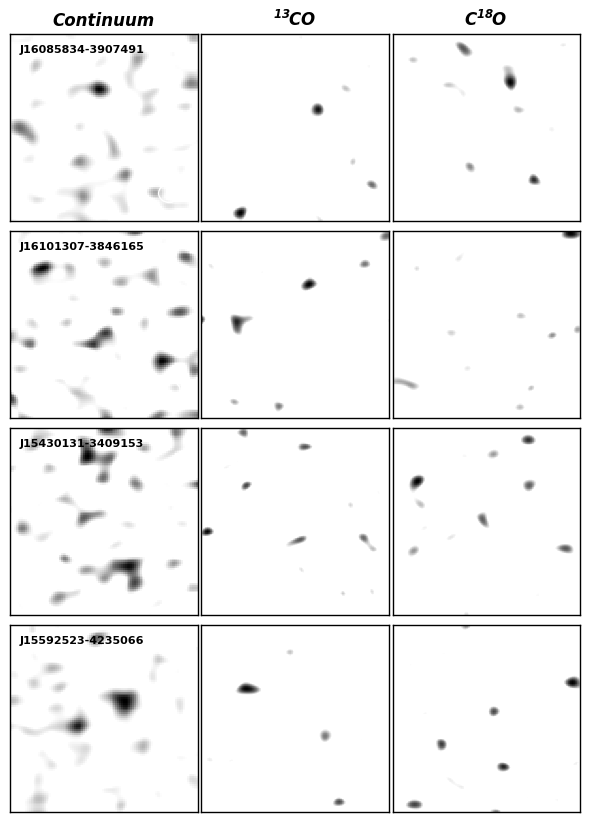

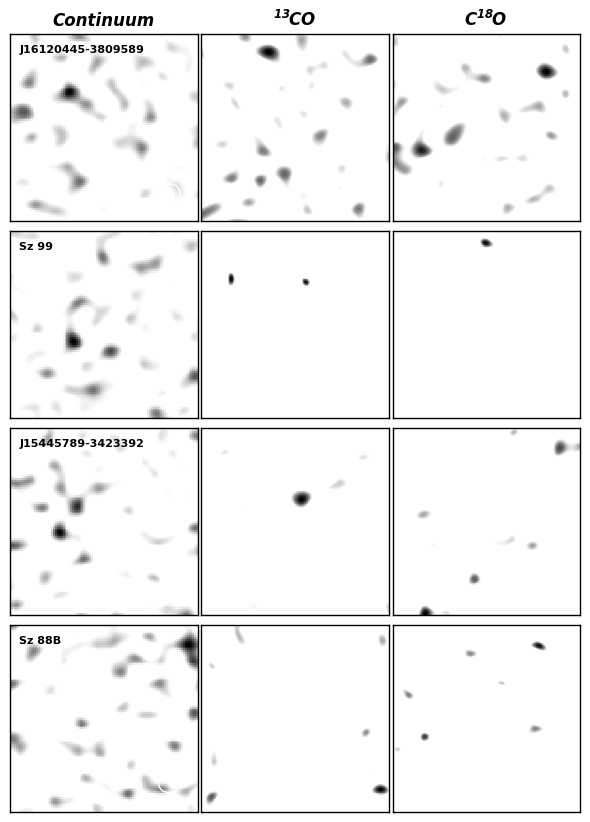

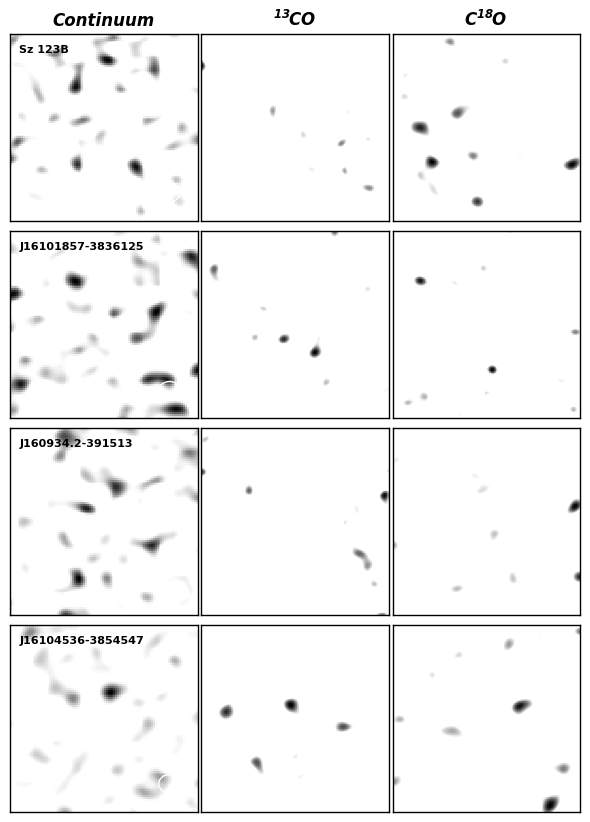

In [14]:
### MAKE PLOTS
count=0
for i, val in enumerate(np.empty(nb_plots)):
    
    ### SETUP PLOT FOR THIS TARGET
    if (i == 0): 
        ind = 0
    if (i != 0) and (i % nb_col == 0): 
        ind = ind + 1
    if i % nb_plots_per_page == 0:
        fig = plt.figure(figsize=(2.0 * nb_col, nb_col * (2.1 * nb_row/nb_col)), dpi=100) 

    ### GET COORDINATES OF OBJECT FROM PAPER TABLE
    de_obj = str(T['DEJ2000'][ind].split(' ')[0][0]) + str(T['DEJ2000'][ind].split(' ')[0][1:]) + 'd' + str(T['DEJ2000'][ind].split(' ')[1]) + 'm' + str(T['DEJ2000'][ind].split(' ')[2]) + 's'
    ra_obj = str(T['RAJ2000'][ind].split(' ')[0]) + 'h' + str(T['RAJ2000'][ind].split(' ')[1]) + 'm' + str(T['RAJ2000'][ind].split(' ')[2]) + 's'
    c_obj = SkyCoord(ra_obj, de_obj, frame='icrs')

    ### CONTINUUM PLOT
    if (i % nb_col == 0):

        ### AXIS LABELS ONLY FOR BOTTOM LEFT
        count +=1
        ax = plt.subplot2grid(grid_size, grid_pos[i % nb_plots_per_page])
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.tick_params(labelbottom='off',labelleft='off')

        ### AXIS TITLE ONLY FOR TOP IMAGE
        if i % nb_plots_per_page == 0:
            ax.set_title('Continuum', fontsize=12, fontweight="bold", fontstyle='italic')

        ### GRAY OUT NON-DETECTION
        snr_cont = T['F890'][ind] / T['e_F890'][ind]
        if snr_cont >= 3.:
            cmap_cont, cfont_cont = 'gnuplot2', 'white'
        else:
            cmap_cont, cfont_cont = 'Greys', 'black'

        ### GET CENTERED & CROPPED IMAGE
        img_cont, beam_cont = get_image(T['Name'][ind], hw_as, '_cont')

        ### PLOT CONTINUUM IMAGE
        ax.imshow(img_cont, extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as],
                  interpolation='none', cmap=cmap_cont, vmin=T['e_F890'][ind], vmax=img_cont.max(), origin='lower')
        
        ### PLOT BEAM & TARGET NAME
        ax = add_beam(beam_cont[0], beam_cont[1], beam_cont[2], hw_as * 0.7, -hw_as * 0.7, 'white', ax)
        ax.text(-1.35, 1.2, T['Name'][ind], fontsize=8, color=cfont_cont, fontweight='bold')

        ### PLOT CONTINUUM CONTOUR
        if snr_cont >= 3.:
            ccont = get_ccont(T['F890'][ind] / T['e_F890'][ind])
            cs = ax.contour(img_cont, 2, levels=[T['rms'][ind] * ccont[0], T['rms'][ind] * ccont[1], T['rms'][ind] * ccont[2]],
                            colors='gray', linewidths=0.5,extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as])
            ax.text(-1.35 ,-1.35, str(int(ccont[0])) + ',' + str(int(ccont[1])) + ',' + str(int(ccont[2])) + r'$\mathregular{\sigma}$',
                    fontsize=7, color=cfont_cont)
 
 
    ### 13CO IMAGE
    if (i % nb_col == 1):

        ### SETUP PLOT; TURN LABELS OFF
        ax = plt.subplot2grid(grid_size, grid_pos[i % nb_plots_per_page])
        ax.tick_params(axis='both', labelsize=4, labelbottom='off', labelleft='off')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if i % nb_plots_per_page == 1:
            ax.set_title(r'$\mathregular{^{13}\!\hspace{0.1}CO}$', fontsize=12, fontweight="bold", fontstyle='italic')

        ### GRAY OUT NON-DETECTION
        if T['l_F13CO'][ind] == '':
            cmap_13co, cfont_13co = 'gnuplot2', 'white'
        else:
            cmap_13co, cfont_13co = 'Greys', 'black'

        ### GET CENTERED & CROPPED IMAGE
        img_13co, beam_13co = get_image(T['Name'][ind], hw_as, '_13co32.mom0')

        ### GET NOISE LIMIT BASED ON IF DET OR NON-DET
        vmin = rms_13co[ind] * 2.0
        if vmin > img_13co.max():
            vmin = 1.5 * rms_13co[ind]
            # print('Using 1.5xrms for 13CO image of ' + T['Name'][ind])

        ### PLOT LINE IMAGE
        ax.imshow(img_13co, extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as], origin='lower',
                  cmap=cmap_13co, norm=mpl.colors.SymLogNorm(linthresh=10, vmin=vmin, vmax=img_13co.max()))

        ### PLOT CONTINUUM CONTOUR
        if snr_cont >= 3.:
            cs = ax.contour(img_cont, 2, levels=[T['rms'][ind] * ccont[0], T['rms'][ind] * ccont[1], T['rms'][ind] * ccont[2]],
                            colors='gray', linewidths=0.5,extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as])
            

    ### C18O IMAGE
    if (i % nb_col == 2):

        ### SETUP PLOT; TURN LABELS OFF
        ax = plt.subplot2grid(grid_size, grid_pos[i % nb_plots_per_page])
        ax.tick_params(axis='both', labelsize=4, labelbottom='off', labelleft='off')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if i % nb_plots_per_page == 2:
            ax.set_title(r'$\mathregular{C^{18}\!\hspace{0.1}O}$', fontsize=12, fontweight="bold", fontstyle='italic')

        ### GRAY OUT NON-DETECTION
        if T['l_F18CO'][ind] == '':
            cmap_18co, cfont_18co = 'gnuplot2', 'white'
        else:
            cmap_18co, cfont_18co = 'Greys', 'black'

        ### GET CENTERED & CROPPED IMAGE
        img_18co, beam_18co = get_image(T['Name'][ind], hw_as, '_c18o32.mom0')
                            
        ### GET NOISE LIMIT BASED ON IF DET OR NON-DET
        vmin = rms_18co[ind] * 2.0
        if vmin > img_18co.max():
            vmin = rms_18co[ind] * 1.5
            # print('Using 1.5xrms for C18O image of ' + T['Name'][ind])

        ### PLOT LINE IMAGE
        ax.imshow(img_18co, extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as], origin='lower',
                  cmap=cmap_18co, norm=mpl.colors.SymLogNorm(linthresh=10, vmin=vmin, vmax=img_18co.max()))

        ### PLOT CONTINUUM CONTOUR
        if snr_cont >= 3.:
            cs = ax.contour(img_cont, 2, levels=[T['rms'][ind] * ccont[0], T['rms'][ind] * ccont[1], T['rms'][ind] * ccont[2]],
                            colors='gray', linewidths=0.5,extent=[-1.0 * hw_as, 1.0 * hw_as, -1.0 * hw_as, 1.0 * hw_as])
                
    # MAKE NEW PAGE IF NEEDED
    if (i+1) % nb_plots_per_page == 0 or (i+1) == nb_plots:
        fig.tight_layout()
        fig.subplots_adjust(hspace=0, wspace=0.02)
        pdf_pages.savefig(fig)

In [15]:
### SAVE FIGURE
plt.close('all')
pdf_pages.close()